### Import modules

First of all, we'll import all useful modules to our notebook.

In [374]:
#Import modules
%matplotlib inline

#handling data
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter

#import twitter credentials
consumer_key = "jjSz1RE4ftTNmqB1XuUTM22Fc"
consumer_secret = "5SNWrhQStzMp3UDwVY7YGuEofQ4QOBBP4rOo4hGnhKpdFQoVi9"
access_token = "68979886-IzdibLmYAx39y8PLNWA7kLPKl2rTDlLPCnf557I45"
access_token_secret = "tjVsF4mx4vS9JO0hPcS7b8qoP7oIZK1A8nX0aMwhkNEDG"

#handling information
import re
import json

#handling plots
import matplotlib.pyplot as plt
import seaborn as sns

#for network creation
import networkx as nx

### Read json to DataFrame

The information that we've collected is stored in the file 'tweets.txt'. Because this file has a JSON format, we'll take advantage of the `read_json` function of the pandas module. 

In [375]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [460]:
!wc -l plandemic_tweets.txt

    4755 plandemic_tweets.txt


In [ ]:
tweets_df = pd.read_json("plandemic_tweets.txt", lines=True)

In [483]:
# Read json into a pandas dataframe
tweets_df = pd.read_json("corona_tweets.txt", lines=True)

According to [Twitter API website](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object), the Tweet object retrieved, provided in JSON format, has a long list of mixed `root-level` attributes, including basic information such as `id`, `created_at`, and `text`. Tweet objects are also the `parent` object to several child objects. Tweet child objects include `user`, `entities`, and extended_entities.

In order to have a better idea of the information we are dealing with, let's take a look at the `DataFrame` columns.

In [378]:
# tweets_df = tweets_df.drop([3833])

In [379]:
# tweets_df = tweets_df[:1000]

In [380]:
# import tweepy
# # assuming twitter_authentication.py contains each of the 4 oauth elements (1 per line)

# consumer_key = "jjSz1RE4ftTNmqB1XuUTM22Fc"
# consumer_secret = "5SNWrhQStzMp3UDwVY7YGuEofQ4QOBBP4rOo4hGnhKpdFQoVi9"
# access_token = "68979886-IzdibLmYAx39y8PLNWA7kLPKl2rTDlLPCnf557I45"
# access_token_secret = "tjVsF4mx4vS9JO0hPcS7b8qoP7oIZK1A8nX0aMwhkNEDG"

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tweepy.API(auth)

# query = 'earth is flat'
# max_tweets = 100
# searched_tweets = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]

In [381]:
# len(searched_tweets)

In [484]:
tweets_df.head()['entities']

0    {'hashtags': [{'text': 'COVID19', 'indices': [...
1    {'hashtags': [{'text': 'LeadFromWithin', 'indi...
2    {'hashtags': [], 'urls': [], 'user_mentions': ...
3    {'hashtags': [{'text': 'COVID19', 'indices': [...
4    {'hashtags': [{'text': 'Cities', 'indices': [2...
Name: entities, dtype: object

In [485]:
tweets_df.user.head()

0    {'id': 1061765396062187520, 'id_str': '1061765...
1    {'id': 1238467680773894146, 'id_str': '1238467...
2    {'id': 1248691356719030272, 'id_str': '1248691...
3    {'id': 1421951876, 'id_str': '1421951876', 'na...
4    {'id': 999161436885606400, 'id_str': '99916143...
Name: user, dtype: object

In [486]:
# Let's check the name of the columns
tweets_df.columns

Index(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'is_quote_status', 'quote_count',
       'reply_count', 'retweet_count', 'favorite_count', 'entities',
       'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms',
       'possibly_sensitive', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'quoted_status_permalink', 'display_text_range',
       'extended_entities', 'extended_tweet', 'withheld_in_countries'],
      dtype='object')

From the displayed columns, we can observe some of them that look interesting for our future analysis. If we look more in detail, certain columns, such as `retweeted_status`, `entities` provide us with information about interactions regarding user mentions and user retweets. So, we are going to create a new `DataFrame` where to store all this important information that will come in handy when we build our Network. 

In [487]:
# Create a second dataframe to put important information
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])

In [488]:
# Columns that are going to be the same
equal_columns = ["created_at", "id", "text"]
tweets_final[equal_columns] = tweets_df[equal_columns]


Now, we need to obtain important information. There are three types of interactions between two Twitter users that we should gather: retweets, replies, and mentions.

From the structure of the [JSON file](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json#tweetobject) retrieved by the Twitter API, we learn that we can obtain basic information about the user: 

In [489]:
# Get the basic information about user 
def get_basics(tweets_final):
    print(tweets_df["user"])
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final

The `entities` object is a dictionary that contains, among other information, the `user_mentions` object that represents other Twitter users (`screen_name` and `id`) mentioned in the text of the Tweet.  

In [490]:
# Get the user mentions 
def get_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final

The retweets always contain two Tweet objects: The original Tweet being Retweeted is provided in a `retweeted_status` object. Inside, the `user` object for the account (`screen_name` and `id`) taking the Retweet action and the time of the Retweet.  

In [491]:
# Get retweets
def get_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final

From the Tweet object, we can get the information of the user and status to which the tweet replies to:

In [492]:
# Get the information about replies
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
    return tweets_final

Now, we define a function that calls all the functions to fill the DataFrame with the usefull variables.

In [493]:
# Lastly fill the new dataframe with the important information
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
    return tweets_final

It's time to get from the DataFrame all the interactions. For this aim, we'll define a function that will iterate over the DataFrame, obtain the user_id and screen_name of the user that the author of that specific tweet mention, reply or retweet. The function will return the user of the specific tweet together with a list of the users with whom the user interacted.

In [494]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

Now, we fill the DataFrame and discard the None values.

In [495]:
# !head -n 1 tweets.txt

In [496]:
for idx, user in enumerate(tweets_df.user):
    if not isinstance(user, dict):
        print(idx, isinstance(user, dict))

In [497]:
tweets_df.user

0       {'id': 1061765396062187520, 'id_str': '1061765...
1       {'id': 1238467680773894146, 'id_str': '1238467...
2       {'id': 1248691356719030272, 'id_str': '1248691...
3       {'id': 1421951876, 'id_str': '1421951876', 'na...
4       {'id': 999161436885606400, 'id_str': '99916143...
                              ...                        
4253    {'id': 914586385750925313, 'id_str': '91458638...
4254    {'id': 325356525, 'id_str': '325356525', 'name...
4255    {'id': 2464826732, 'id_str': '2464826732', 'na...
4256    {'id': 1032276916168998912, 'id_str': '1032276...
4257    {'id': 1357931292, 'id_str': '1357931292', 'na...
Name: user, Length: 4258, dtype: object

In [498]:
tweets_final = fill_df(tweets_final)

0       {'id': 1061765396062187520, 'id_str': '1061765...
1       {'id': 1238467680773894146, 'id_str': '1238467...
2       {'id': 1248691356719030272, 'id_str': '1248691...
3       {'id': 1421951876, 'id_str': '1421951876', 'na...
4       {'id': 999161436885606400, 'id_str': '99916143...
                              ...                        
4253    {'id': 914586385750925313, 'id_str': '91458638...
4254    {'id': 325356525, 'id_str': '325356525', 'name...
4255    {'id': 2464826732, 'id_str': '2464826732', 'na...
4256    {'id': 1032276916168998912, 'id_str': '1032276...
4257    {'id': 1357931292, 'id_str': '1357931292', 'na...
Name: user, Length: 4258, dtype: object


Be aware of None values!

In [499]:
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)

In [500]:
tweets_final.head(5)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count
0,2020-05-12 21:35:14+00:00,1260322666973716481,None,None,None,702299726557806592,lana_kyla,lana_kyla,702299726557806592,RT @lana_kyla: Due to #COVID19 aka #Coronaviru...,1061765396062187520,ItssEddie4,55
1,2020-05-12 21:35:14+00:00,1260322666835177472,None,None,None,16248319,LollyDaskal,LollyDaskal,16248319,RT @LollyDaskal: NEW: Leave Your Door Open Whe...,1238467680773894146,CoronaUpdateBot,662
2,2020-05-12 21:35:14+00:00,1260322668076830721,None,None,None,1027527078,FreedomsAus,FreedomsAus,1027527078,RT @FreedomsAus: Pope Francis is inviting all ...,1248691356719030272,naigr77,14
3,2020-05-12 21:35:14+00:00,1260322668894498816,None,None,None,407395156,CaulfieldTim,CaulfieldTim,407395156,RT @CaulfieldTim: Soon: Chatting with @jillrep...,1421951876,FriendsOfSciMed,2887
4,2020-05-12 21:35:14+00:00,1260322668995215360,None,None,None,356440164,Stevo4747,Stevo4747,356440164,RT @Stevo4747: The 10 US #Cities Best Position...,999161436885606400,lizandhercats,26


In [501]:
all_hashtags = []
for e in tweets_df.entities:
    hashtags = [t['text'] for t in e['hashtags']]
    all_hashtags = all_hashtags + hashtags

from collections import Counter
c = Counter(all_hashtags)
most_common_tuples = c.most_common()
sorted_keys = sorted(c, key=c.get, reverse=True)
most_common_tuples

[('coronavirus', 1290),
 ('COVID19', 426),
 ('Coronavirus', 419),
 ('COVIDー19', 68),
 ('covid19', 46),
 ('China', 41),
 ('CoronaVirus', 38),
 ('Fauci', 34),
 ('water', 26),
 ('CORONAVIRUS', 22),
 ('NewNormal', 22),
 ('lockdown', 22),
 ('Covid_19', 16),
 ('Iran', 15),
 ('COVID', 15),
 ('Trump', 14),
 ('USA', 13),
 ('TuesdayMotivation', 12),
 ('misinformation', 12),
 ('Covid19', 12),
 ('GRAVITAS', 12),
 ('ObamaGate', 11),
 ('InternationalNursesDay', 11),
 ('IraqProtests', 11),
 ('Sweden', 10),
 ('WhiteHouse', 10),
 ('Trump2020', 9),
 ('KAG2020', 9),
 ('poverty', 9),
 ('podcasts', 9),
 ('pandemic', 9),
 ('BillGates', 9),
 ('FakeNews', 8),
 ('FoxAndFriends', 8),
 ('MorningJoe', 8),
 ('CCP', 8),
 ('StayAlert', 8),
 ('NorthAmerica', 8),
 ('BorisJohnson', 7),
 ('books', 7),
 ('ChineseVirus', 7),
 ('SARSCoV2', 7),
 ('BREAKING', 7),
 ('Travel', 6),
 ('Trump2020Landslide', 6),
 ('Israel', 6),
 ('SocialDistancing', 6),
 ('QAnon', 6),
 ('hospital', 6),
 ('health', 6),
 ('StayAtHome', 6),
 ('Heroes

In [400]:

# tweets_final.user_mentions_id = tweets_final.user_mentions_id.map(lambda x: int(x) if x is not None else None)

In [401]:
# import math

# tweets_final.user_id = tweets_final.user_id.astype(int)

# tweets_final.user_mentions_id = tweets_final.user_mentions_id.map(lambda x: int(x) if x is not math.isnan(x) else None)


# tweets_final.in_reply_to_status_id = tweets_final.in_reply_to_status_id.map(lambda x: int(x) if x is not None else None)
# tweets_final.in_reply_to_user_id = tweets_final.in_reply_to_user_id.map(lambda x: int(x) if x is not None else None)
# tweets_final.retweeted_id = tweets_final.retweeted_id.map(lambda x: int(x) if x is not None else None)


Now, it's time to initialize the Graph. We can do this by calling the function .Graph() of NetworkX.

In [402]:
graph = nx.Graph()

There are two other important functions to create a Graph. The first one is add_node()and the second one, add_edge both with a very descriptive name. Let's pay attention to the syntax of add_edge:  

`Graph.add_edge(u_of_edge, v_of_edge, **attr)`  

where `u`, `v` are the nodes, and attr are keyword arguments that characterize the edge data such as weight, capacity, length, etc.
  
If we add an edge that already exists, the edge data will get updated. Also, if we are an edge between two nodes that are still not in the Graph, the nodes will be created in the process.
We are going to populate the Graph by calling the function get_interactions that we defined earlier. With this information, we apply the function add_edge to every tuple consisting of the tweet's user_id and the user_id of the user mentioned, replied to or retweeted, creating the nodes and the edges connecting them. Also, the tweet id will be added as edge data.

In [403]:
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = int(tweet["id"])
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.node[user_id]["name"] = user_name
        graph.node[int_id]["name"] = int_name     

In [404]:
graph.nodes

NodeView((77326234, '826419253347745792', 245662720, '1589798682', 1102521575205675009, '14805088', 794397081427394560, '377735275', 1246791474093551617, '2725865306', 573722633, '1090451602471899136', 3688675460, '574719681', 297778185, '878247600096509952', 8.7824760009651e+17, 1106361613119090688, 1244015006636802049, '1252167955842060291', 1147272722990260224, '35013035', 23194229, '18206185', 1258211850996592646, '948688862', 1060968143936516097, '360743972', '50512313', 1088850217250816000, 1246637793276723200, '1246901598862934017', 1211767345686835200, 938338204834344960, 1137227405381103616, 807095.0, '807095', 355497196, 1108061005953679360, '40414437', 860434087, '79654987', '1252316692501295104', 965121867790127104, '785676811', '866264255783256065', 1258802451014180869, '759855850496389120', 7.598558504963891e+17, 191992069, '1001031324617117696', 155309802, 1213377219000557570, '423890530', 1083360182447554560, 1184299498157199360, 877140333473271809, 1232025534256812032,

In [405]:
# for n in graph.nodes:
#     n = int(n)

Now that we have the node and edge of the Graph created, let's see the number of nodes and edges present:

In [406]:
n

nan

In [407]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 3486 nodes and 3089 edges present in the Graph


The degree of a node u, denoted as deg(u), is the number of edges that occur to that node. In simpler words, the number of connections a particular node has. The maximum degree of a graph and the minimum degree of a graph are the maximum and minimum degree of its nodes, respectively.

In [408]:
degrees = [val for (node, val) in graph.degree()]

In [409]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")  

The maximum degree of the Graph is 297
The minimum degree of the Graph is 1


In [410]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 

The average degree of the nodes in the Graph is 1.8
The most frequent degree of the nodes found in the Graph is 1


An undirected graph is connected if, for every pair of nodes, there is a path between them. For that to happen, most of the nodes should have at least a degree of two, except for those denominated leaves which have a degree of 1. From the characteristics of the Graph, we can suspect that the graph is not connected. In order to confirm these, we can use `nx.is_connected`.

In [411]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


Now, that we confirm that our Graph is not connected, we can check how many connected components it has:

In [412]:
sorted(nx.connected_component_subgraphs(graph), key=len)[-1].number_of_nodes()

1784

In [413]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")  

There are 518 connected components in the Graph


In [414]:
largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)

In [415]:
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 1784 nodes and 1874 edges present in the largest component of the Graph


In [416]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


Clustering and transitivity measure the tendency for nodes to cluster together or for edges to form triangles. In our context, they are measures of the extent to which the users interacting with one particular user tend to interact with each other as well. The difference is that transitivity weights nodes with a large degree higher. 
The clustering coefficient, a measure of the number of triangles in a graph, is calculated as the number of triangles connected to node i divided by the number of sets of two edges connected to node i (Triple nodes). While the transitivity coefficient is calculated as 3 multiply by the number of triangles in the network divided by the number of connected triples of nodes in the network. These two parameters are very important when analyzing social networks because it gives us an insight into how users tend to create tightly knot groups characterized by relatively high-dense ties.

In [417]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0


After that, we'll investigate some summary statistics, particularly related to distance, or how far away one node is from another random node. Diameter represents the maximum distance between any pair of nodes while the average distance tells us the average distance between any two nodes in the network.

In [418]:
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of our Graph is 19
The average distance between any two nodes is 6.49


Now, we are going to focus on **network centrality** which captures the importance of a node's position in the network considering: degree on the assumption that an important node will have many connections, closeness on the assumption that important nodes are close to other nodes, and finally, betweenness on the assumption that important nodes are well situated and connect other nodes. For this, we are going to use the following functions `degree_centrality`, `closenness_centrality` and `betwenness_centrality`, all which return a list of each node and its centrality score. We will particularly capture the node with the best score in each one.

In [419]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [420]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [421]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [422]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [423]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [424]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [425]:
all_bet = sorted(graph_betweenness.items(), key=itemgetter(1))

In [426]:
all_bet.reverse()

In [427]:
#Finding influencers 
for bet in all_bet[:10]:
    print(bet[0])

35013035
3580248555
424664120
2725865306
826419253347745792
776638213
948688862
827269043795005441
482940372
1251638956359385089


In [428]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 35013035 has a degree centrality of 0.17 which is the maximum of the Graph
the node with id 35013035 has a closeness centrality of 0.28 which is the maximum of the Graph
the node with id 35013035 has a betweenness centrality of 0.73 which is the maximum of the Graph


Now, we can get to see how the Graph looks like. For that, we will use nx.drawing.layout to apply node positioning algorithms for the graph drawing. Specifically, we will use spring_layout that uses force-directed graph drawing which purpose is to position the nodes in two-dimensional space so that all the edges are of equal length and as few crossing edges as possible. It achieves this by assigning forces among the set of edges and nodes based on their relative positions and then uses this to simulate the motion of the edges and nodes. One of the parameters that we can adjust is k, the optimal distance between nodes; as we increase the value, the nodes will farther apart.  Once, that we got the positions, we are also going to create a special list so that we can draw the two nodes with higher centrality that we found in different colors to highlight them.

In [429]:
max_bet

('35013035', 0.7324753759118563)

In [430]:
len(node_and_degree)

1283

In [431]:
tweets_final.head(10)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count
0,2020-05-11 18:22:21+00:00,1259911741275856896,None,None,None,826419253347745792,99freemind,99freemind,826419253347745792,RT @99freemind: At the same time as the Global...,77326234,dball88,1637
1,2020-05-11 18:22:21+00:00,1259911742068600833,None,None,None,None,None,None,None,#Plandemic #BorisHasFailed #coronavirus #endth...,3059442951,ChineryKathryn,18
2,2020-05-11 18:22:36+00:00,1259911804794204160,None,None,None,None,None,None,None,#ProtestLockdown #Questionauthority ##Plandemi...,1251334895537754112,mollydu53504827,15
3,2020-05-11 18:22:50+00:00,1259911860415070208,None,None,None,1589798682,jharrigan23,jharrigan23,1589798682,RT @jharrigan23: The WORLD says NO to Gates va...,245662720,frideknor,318
4,2020-05-11 18:22:55+00:00,1259911883664089088,None,None,None,None,None,None,None,#GOLD #GOLDMINES #CONSPIRACY #ECONOMY #CORONAV...,1252656507868663809,StillnessStorm,1468
5,2020-05-11 18:23:03+00:00,1259911914341249024,None,None,None,14805088,MirelaMonte,MirelaMonte,14805088,RT @MirelaMonte: The new essentials...\n\n#PLA...,1102521575205675009,ShanqiueB,397
6,2020-05-11 18:23:06+00:00,1259911928111149058,None,None,None,377735275,formerbondgirl,formerbondgirl,377735275,RT @formerbondgirl: It took me a min to wake u...,794397081427394560,truthpiks,7540
7,2020-05-11 18:23:14+00:00,1259911962886012928,None,None,None,None,None,None,None,#PlanDemic. Tell me again how there's somethi...,18206185,xformed,15704
8,2020-05-11 18:23:19+00:00,1259911982414622720,None,None,None,2725865306,BeachMilk,BeachMilk,2725865306,RT @BeachMilk: In the next #Plandemic later th...,1246791474093551617,tamtam_run_run,79
9,2020-05-11 18:23:46+00:00,1259912097770737664,None,None,None,1090451602471899136,KIMAGA4EVER,KIMAGA4EVER,1090451602471899136,RT @KIMAGA4EVER: Stealing the election is what...,573722633,LeahHermann,47


In [432]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange']
central_nodes = ['35013035']

In [433]:
# tweets_final[tweets_final]

In [434]:
pos = nx.spring_layout(largest_subgraph, k=0.05)

After all that calculation, we'll use the functions `.draw_networkx_nodes()` and `.draw()`. And finally, we have the drawing of the largest connected component of our original Graph:

In [436]:
tweets_df[tweets_df.user_id == 35013035]

AttributeError: 'DataFrame' object has no attribute 'user_id'

In [435]:
len(node_and_degree)

1784

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



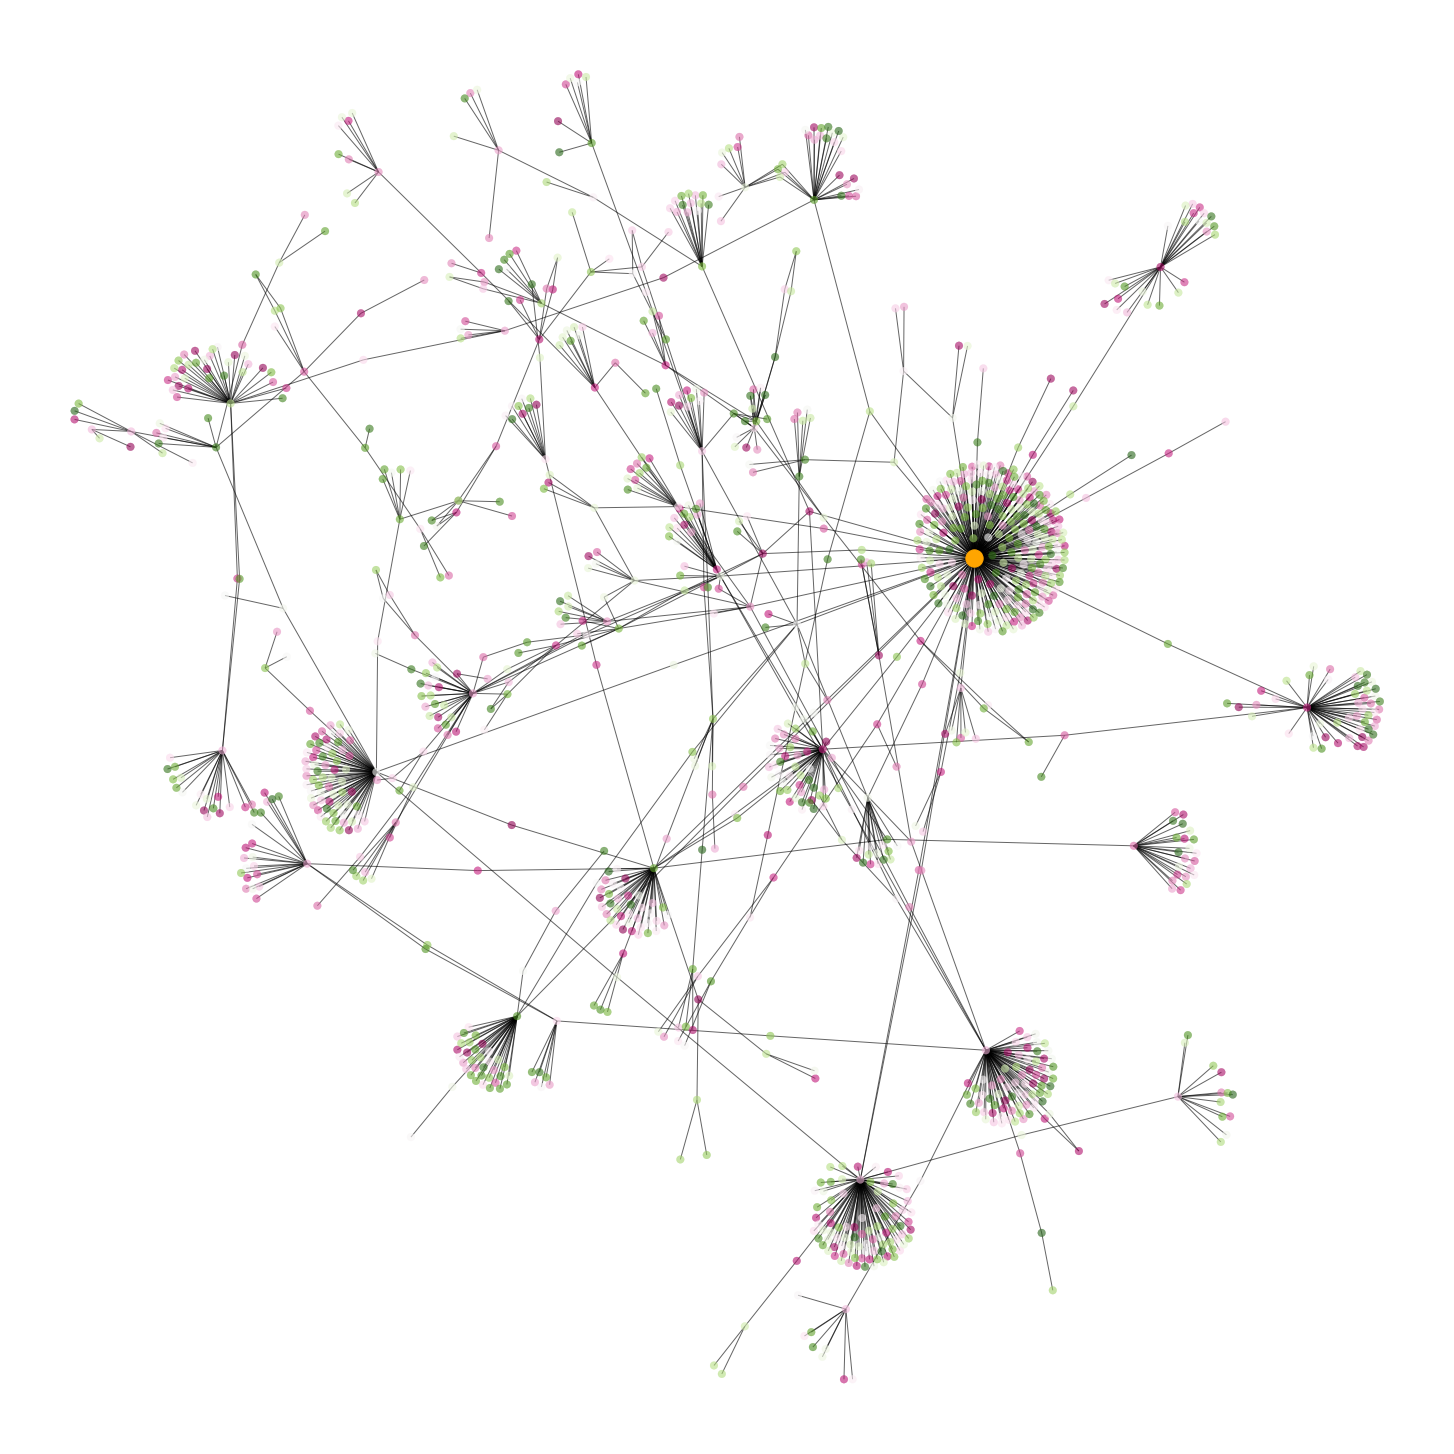

In [368]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(len(node_and_degree)), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('graphfinal.png')
plt.show()

In [483]:
graph.nodes

NodeView((946034749, '2800581040', 3598959794, '25073877', 1208056700374257664, 25073877.0, 271403087, '110998031', 375854213, '375854213', 4228595532, '18166778', 3033794473, 263226490, '1957146504', 1199318835687559168, 543812845, '343578695', 1194941149946843137, '131546062', 1189330590971154433, '939091', 1016451712658395139, '47747074', 337470798, '9300262', 1241033789037559810, '742143', 733403248531406849, '78523300', 4607045536, '822215673812119553', 582654922, 784574775163248640, 3053379708, '251219812', 1714862971, '65867767', 3229781030, '24733117', 3244922072, '152557039', 537500483, '133038164', 1556631295, '18266688', 62532680, 1250393179423203330, 3245926472, '2396864504', 717516707510620160, '796905806818144256', 1157896286047277056, '160952087', 31475789, '528316812', 1150779169787338752, 363041417, '27493883', 42239729, '759011715770003457', 1347400062, '1009466031922917379', 3316284854, '14635408', 1150901818861469697, '4620298132', 814316767665418248, '270921976', '

In [507]:
largest_subgraph

In [278]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(largest_subgraph)

In [279]:
len(largest_subgraph)

554

In [280]:
# from networkx.algorithms import community
# communities_generator = community.girvan_newman(largest_subgraph)

In [281]:
# !wc -l tweets.txt

In [282]:
# import itertools
# for communities in itertools.islice(communities_generator, 10):
#     print(tuple(sorted(c) for c in communities)) 

In [283]:

top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

top_level_community_dict = {}
top_level_community_list = []

for index, community in enumerate(top_level_communities):
    intermediate_list = []
    for node in community: 
#         print('here')
        top_level_community_dict[node] = index
        intermediate_list.append(node)
    top_level_community_list.append(intermediate_list)


next_level_community_dict = {}
next_level_community_list = []
for index, community in enumerate(next_level_communities):
    intermediate_list = []
    for node in community: 
        next_level_community_dict[node] = index
        intermediate_list.append(node)
    next_level_community_list.append(intermediate_list)

In [285]:
len(next_level_community_list)

3

In [286]:
community_dict = {}
for index, community in enumerate(top_level_community_list):
    for node in community: 
        community_dict[node] = index

In [287]:
for edge in largest_subgraph.edges():
    print(edge)
    break

(1106361613119090688, '826419253347745792')


In [289]:
pos[1106361613119090688]

array([-0.22147641, -0.15702206])

In [290]:
edge_x = []
edge_y = []
for edge in largest_subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [292]:
import plotly.graph_objects as go

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in largest_subgraph.nodes():
#     x, y = largest_subgraph.nodes[node]['pos']
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Greens',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [530]:
for a, b in enumerate(largest_subgraph.adjacency()):
    print(a,list(b[1].keys())[0])

0 25073877
1 25073877
2 25073877
3 25073877
4 25073877
5 25073877
6 25073877
7 25073877
8 25073877
9 25073877
10 25073877
11 25073877
12 25073877
13 25073877
14 25073877
15 78523300
16 25073877
17 18166778
18 25073877
19 25073877
20 25073877
21 25073877
22 18166778
23 25073877
24 78523300
25 18166778
26 25073877
27 18166778
28 25073877
29 78523300
30 22203756
31 18166778
32 25073877
33 25073877
34 1228476144233611271
35 25073877
36 25073877
37 25073877
38 25073877
39 25073877
40 25073877
41 78523300
42 18166778
43 18166778
44 25073877
45 18166778
46 25073877
47 25073877
48 25073877
49 25073877
50 25073877
51 22203756
52 18166778
53 25073877
54 25073877
55 25073877
56 25073877
57 25073877
58 25073877
59 25073877
60 25073877
61 25073877
62 25073877
63 18166778
64 25073877
65 25073877
66 25073877
67 25073877
68 25073877
69 25073877
70 25073877
71 25073877
72 25073877
73 25073877
74 25073877
75 78523300
76 1208056700374257664
77 18166778
78 1009767521640157184
79 25073877
80 18166778
81 78

In [608]:
tweets_final.head()

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count
0,2020-05-10 11:57:32+00:00,1259452509535391744,None,None,None,2800581040,BillKristol,BillKristol,2800581040,RT @BillKristol: There's apparently a ton to t...,946034749,bjaycat1985,2476
1,2020-05-10 11:57:32+00:00,1259452509694775296,None,None,None,25073877,realDonaldTrump,realDonaldTrump,25073877,RT @realDonaldTrump: Thank you Mike!,3598959794,ver_wey,7634
2,2020-05-10 11:57:32+00:00,1259452509535551488,realDonaldTrump,1259450328048709632,25073877,None,None,realDonaldTrump,25073877,@realDonaldTrump When you have to tear someone...,1208056700374257664,MikeHardin63,11
3,2020-05-10 11:57:32+00:00,1259452509740924928,None,None,None,None,None,None,None,Though i dont blame china..nd neither do i su...,1248536546745016321,AkhilGupta0013,5
4,2020-05-10 11:57:32+00:00,1259452510000971776,None,None,None,110998031,BeirutCityGuide,BeirutCityGuide,110998031,RT @BeirutCityGuide: Lebanese Minister of Inte...,271403087,helmi_deris,269


In [611]:
tweets_final[(tweets_final.retweeted_id == '25073877') & (tweets_final.user_id == 3598959794) ][['text', 'followers_count']].values.tolist()

[['RT @realDonaldTrump: Thank you Mike!', 7634],
 ['RT @realDonaldTrump: We are getting great marks for the handling of the CoronaVirus pandemic, especially the very early BAN of people from…',
  7634]]

In [312]:
list(adjacencies[1].keys())[0]

'35013035'

In [313]:
list(adjacencies[1].keys())[0]

'35013035'

In [623]:
adjacencies[1]

{'25073877': {'tweet_id': 1259452515868913664}}

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count
0,2020-05-11 18:22:21+00:00,1259911741275856896,None,None,None,826419253347745792,99freemind,99freemind,826419253347745792,RT @99freemind: At the same time as the Global...,77326234,dball88,1637
1,2020-05-11 18:22:21+00:00,1259911742068600833,None,None,None,None,None,None,None,#Plandemic #BorisHasFailed #coronavirus #endth...,3059442951,ChineryKathryn,18
2,2020-05-11 18:22:36+00:00,1259911804794204160,None,None,None,None,None,None,None,#ProtestLockdown #Questionauthority ##Plandemi...,1251334895537754112,mollydu53504827,15
3,2020-05-11 18:22:50+00:00,1259911860415070208,None,None,None,1589798682,jharrigan23,jharrigan23,1589798682,RT @jharrigan23: The WORLD says NO to Gates va...,245662720,frideknor,318
4,2020-05-11 18:22:55+00:00,1259911883664089088,None,None,None,None,None,None,None,#GOLD #GOLDMINES #CONSPIRACY #ECONOMY #CORONAV...,1252656507868663809,StillnessStorm,1468


In [320]:
tweets_df[tweets_final['user_id']==77326234]

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,entities,favorited,retweeted,filter_level,lang,timestamp_ms,extended_tweet,possibly_sensitive,extended_entities,display_text_range
0,2020-05-11 18:22:21+00:00,1259911741275856896,1259911741275856896,RT @99freemind: At the same time as the Global...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,nan,nan,nan,nan,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-05-11 18:22:21.805,NaN,nan,NaN,NaN


In [300]:
next_level_community_dict[list(adjacencies[1].keys())[0]]

1

In [323]:
largest_subgraph.node['25073877']

KeyError: '25073877'

In [298]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(largest_subgraph.adjacency()):
    # node_adjacencies.append(len(adjacencies[1]))
    # node_text.append('# of connections: '+str(len(adjacencies[1])))

    node_adjacencies.append(next_level_community_dict[list(adjacencies[1].keys())[0]])
#     node_text.append('#community: '+ str(next_level_community_dict[list(adjacencies[1].keys())[0]]))
    node_text.append('<div>#userid: '+ str(0) + '</div>')
    
#     vals = tweets_final[(tweets_final.retweeted_id == list(adjacencies[1].keys())[0]) & (tweets_final.user_id == list(adjacencies[1].keys())[1]) ][['text', 'followers_count']].values.tolist()
#     node_text.append('#vals: '+ str(vals))
#     print(vals)


node_trace.marker.color = node_adjacencies
print(node_adjacencies)
node_trace.text = node_text

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [299]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [482]:
G = graph


In [533]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(largest_subgraph)

In [534]:
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

In [535]:
top_level_community_dict = {}
top_level_community_list = []

for index, community in enumerate(top_level_communities):
    intermediate_list = []
    for node in community: 
        top_level_community_dict[node] = index
        intermediate_list.append(node)
    top_level_community_list.append(intermediate_list)


next_level_community_dict = {}
next_level_community_list = []
for index, community in enumerate(next_level_communities):
    intermediate_list = []
    for node in community: 
        next_level_community_dict[node] = index
        intermediate_list.append(node)
    next_level_community_list.append(intermediate_list)

In [536]:
print(len(next_level_community_list), len(top_level_community_list))

3 2


In [540]:
import random
 
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        
        
        ret.append('#%02x%02x%02x' % (r, g, b)) 
    return ret

In [545]:
color_list = colors(len(next_level_community_list))

In [546]:
color_list

['#909d9c', '#e5f2f1', '#3a4746']

In [469]:
top_level_community_list.sort(key=len)

In [471]:
top_level_community_list.reverse()

In [476]:
for c in top_level_community_list:
    print(len(c))

124
39
19
14
12
10
10
9
9
8
8
8
7
7
7
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


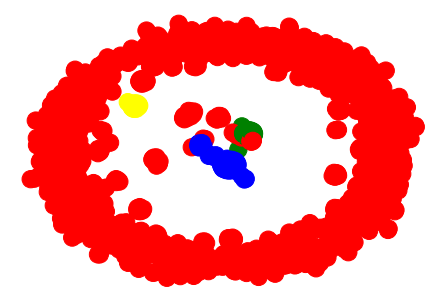

In [474]:
import networkx as nx
import matplotlib.pyplot as plt
# plot the communities
color_map = []
for node in G:
    if node in top_level_community_list[0]:
        color_map.append('blue')
    elif node in top_level_community_list[1]: 
        color_map.append('green')  
    elif node in top_level_community_list[2]: 
        color_map.append('yellow')
    else:
        color_map.append('red')

nx.draw(G, node_color=color_map)
plt.show()

In [404]:
len(tweets_df)

100

In [477]:
!pip install karateclub

done
  Created wheel for smart-open: filename=smart_open-2.0.0-cp37-none-any.whl size=101343 sha256=e3c1c1fd296b27bb2d6b7f7260d77df5b8d2cf9a537014d66614e9bf59b826ec
  Stored in directory: /Users/johnjoy/Library/Caches/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built karateclub python-louvain smart-open


In [478]:
import networkx as nx
from karateclub import EgoNetSplitter

g = nx.newman_watts_strogatz_graph(1000, 20, 0.05)

splitter = EgoNetSplitter(1.0)

splitter.fit(g)

print(splitter.get_memberships())

{0: [0, 2, 3], 1: [0, 4], 2: [0, 5], 3: [0], 4: [0], 5: [0, 6, 7, 8], 6: [0], 7: [0], 8: [0, 9], 9: [0], 10: [1], 11: [1, 10], 12: [1, 11], 13: [1, 12], 14: [1], 15: [1, 13], 16: [1, 14], 17: [1], 18: [1, 15], 19: [1, 16, 17, 18], 20: [1], 21: [1, 19, 20], 22: [1, 21, 22], 23: [1], 24: [1, 23, 24], 25: [1, 25, 26], 26: [1], 27: [1, 27], 28: [1, 28, 29], 29: [1, 30], 30: [1, 31], 31: [1], 32: [1, 32], 33: [1], 34: [1, 33, 34, 35], 35: [1, 36], 36: [1], 37: [1, 37, 38], 38: [1], 39: [1, 39, 40, 41], 40: [1, 42, 43], 41: [1, 44], 42: [1, 45], 43: [1, 46], 44: [1, 48, 49], 45: [7, 1, 50], 46: [1, 51], 47: [1, 52, 53], 48: [1], 49: [1, 54], 50: [1, 55], 51: [1], 52: [1], 53: [1], 54: [47, 56, 57], 55: [47], 56: [47, 58], 57: [47], 58: [47, 59, 60], 59: [47, 61, 62], 60: [47, 63], 61: [47, 64], 62: [47], 63: [47], 64: [25, 47, 65, 66], 65: [47, 67, 68], 66: [47, 69], 67: [47, 70, 0], 68: [35, 47], 69: [47], 70: [47, 71], 71: [47], 72: [47, 72, 73], 73: [47], 74: [47], 75: [47, 74], 76: [47, 

In [486]:
splitter = EgoNetSplitter(1.0)

splitter.fi

print(splitter.get_memberships())

NameError: name 'exit' is not defined

In [481]:
from karateclub import GraphReader

reader = GraphReader("facebook")

graph = reader.get_graph()
target = reader.get_target()

KeyboardInterrupt: 

In [488]:
reader.get_features()

TypeError: 'coo_matrix' object is not subscriptable